In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.0-preview2-bin-hadoop2.7/
spark-3.0.0-preview2-bin-hadoop2.7/data/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/sample_movielens_rati

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
MsNPC = spark.read.option("inferSchema","true").csv("MsNPC.csv", header = True)
MsPlayer = spark.read.option("inferSchema", "true").csv("MsPlayer.csv", header = True)
MsWeapon = spark.read.option("inferSchema", "true").csv("MsWeapon.csv", header = True)
MsWeaponType = spark.read.option("inferSchema", "true").csv("MsWeaponType.csv", header = True)
TransactionDetail = spark.read.option("inferSchema", "true").csv("TransactionDetail.csv", header = True)
TransactionHeader = spark.read.option("inferSchema", "true").csv("TransactionHeader.csv", header = True)

In [0]:
MsNPC.createOrReplaceTempView("MsNPC")
MsPlayer.createOrReplaceTempView("MsPlayer")
MsWeapon.createOrReplaceTempView("MsWeapon")
MsWeaponType.createOrReplaceTempView("MsWeaponType")
TransactionDetail.createOrReplaceTempView("TransactionDetail")
TransactionHeader.createOrReplaceTempView("TransactionHeader")


In [0]:
no1 = spark.sql("""
SELECT wt.WeaponTypeId, wt.WeaponTypename,SUM(Weaponprice*Quantity) as Revenue FROM MsWeaponType wt
JOIN MsWeapon w ON wt.WeaponTypeId = w.WeaponTypeId
JOIN TransactionDetail td ON w.WeaponId = td.WeaponId
JOIN TransactionHeader th ON td.TransactionId = th.TransactionId
GROUP BY wt.WeaponTypeId, WeaponTypeName
ORDER BY Revenue
""")

In [0]:
no1 = no1.toPandas()


In [452]:
type(no1['Revenue'])

pandas.core.series.Series

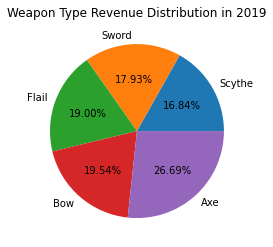

In [453]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(no1['Revenue'], labels = no1['WeaponTypename'], autopct='%.2f%%')
plt.show()

In [0]:
no2 = spark.sql("""
   SELECT MONTH(TransactionDate) as Month, Count(DISTINCT th.PlayerId) as PlayerCount FROM TransactionHeader th
   JOIN MsPlayer p ON th.PlayerId = p.PlayerId
   JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
   JOIN MsWeapon w ON td.WeaponId = w.WeaponId
   WHERE YEAR(TransactionDate) = 2019 AND w.WeaponTypeId = 2
   GROUP BY MONTH(TransactionDate)
   ORDER BY MONTH             
""")

In [0]:
no2 = no2.toPandas()

In [168]:
type(no2['PlayerCount'])

pandas.core.series.Series

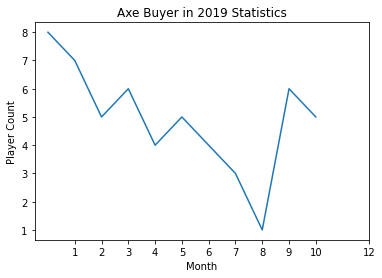

In [171]:
plt.plot(no2['PlayerCount'])
plt.xticks(no2['Month'])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [0]:
no3 = spark.sql("""
SELECT Item, COUNT(Item) as Frequency
FROM(
  SELECT PlayerId,
    (CASE
      WHEN MonthlySpending BETWEEN 1000000 AND 1499999 THEN "Storm Breaker"
      WHEN MonthlySpending BETWEEN 1500000 AND 1999999 THEN "Nightfall"
      ELSE "Extinction"
    END) AS Item
  FROM(
    SELECT p.PlayerId, p.PlayerGender, MONTH(TransactionDate) as MONTH, SUM(WeaponPrice*Quantity) as MonthlySpending FROM MsPlayer p
    JOIN TransactionHeader th ON p.PlayerId = th.PlayerId
    JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
    JOIN MsWeapon w ON td.WeaponId = w.WeaponId
    WHERE p.PlayerGender = "Female" AND YEAR(Transactiondate) = 2019
    GROUP BY p.PlayerId, MONTH(TransactionDate), p.playerGender
    ORDER BY MONTH
     ) x
     WHERE MonthlySpending > 1000000
   ) y
GROUP BY Item
""")

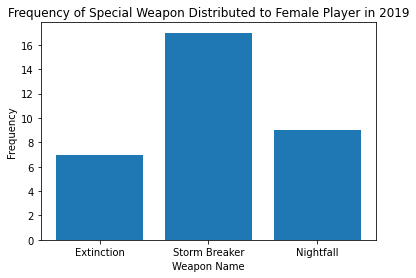

In [253]:
no3 = no3.toPandas()
plt.bar(C['Item'], no3['Frequency'])
plt.title("Frequency of Special Weapon Distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [0]:
no4 = spark.sql("""
  SELECT COUNT(Playerid) as PlayerCount, Month
  FROM(
   SELECT p.PlayerId, MONTH(TransactionDate) as Month, Count(DISTINCT WeaponTypeId) as TypeCount FROM TransactionHeader th
   JOIN MsPlayer p ON th.PlayerId = p.PlayerId
   JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
   JOIN MsWeapon w ON td.WeaponId = w.WeaponId
   WHERE YEAR(TransactionDate) = 2019
   GROUP BY p.PlayerId, MONTH(TransactionDate)
   ORDER BY TypeCount DESC
   )
   WHERE TypeCount > 2
   GROUP BY Month
   ORDER BY Month       
""")

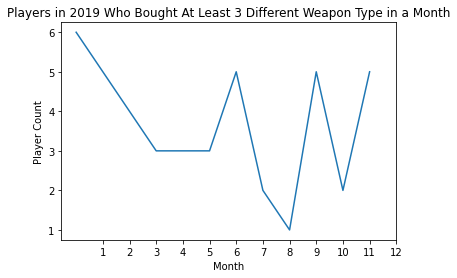

In [286]:
no4 = no4.toPandas()
plt.plot(no4['PlayerCount'])
plt.xticks(no4['Month'])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [0]:
no5 = spark.sql("""
SELECT Pop, COUNT(Pop) as Frequency
FROM(
  SELECT NPCId, Income,
    (CASE
        WHEN Income BETWEEN 7500000 AND 14999999 THEN "Popular"
        WHEN Income BETWEEN 2500000 AND 7499999 THEN "Quite Popular"
        ELSE "Very Popular"
        END
    ) AS Pop
FROM (
    SELECT n.NPCId, SUM(WeaponPrice*Quantity) as Income, COUNT(DISTINCT th.PlayerId) as PlayerCount FROM TransactionHeader th
    JOIN MsNPC n ON th.NPCId = n.NPCId
    JOIN MsPlayer p ON th.PlayerId = p.PlayerId  
    JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
    JOIN MsWeapon w ON td.WeaponId = w.WeaponId
    GROUP BY n.NPCId
    ORDER BY n.NPCId
    ) y
    WHERE PlayerCount > 4 AND Income > 2500000
    GROUP BY NPCId, Income
    ORDER BY NPCId  
) z

GROUP BY Pop

""")

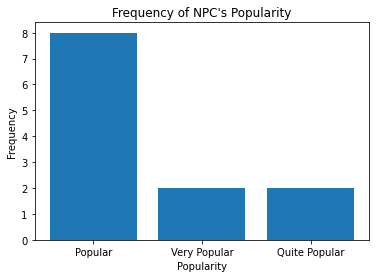

In [336]:
no5 = no5.toPandas()
plt.bar(E['Pop'], E['Frequency'])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()